<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb  9 15:33:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install yfinance

In [4]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [13]:
folder = '/content/drive/MyDrive/Trading/7_days_v3/'
past_t = 7
forecast_t = 7

In [14]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [15]:
# Fear index
df_fear = pd.read_csv('/content/drive/MyDrive/Trading/fear_index.csv')
df_fear = df_fear[df_fear.date.between('2018-02-01', '2022-01-31')]
df_fear['date'] = pd.to_datetime(df_fear['date'])
df['date'] = pd.to_datetime(df.index)
df = df.join(df_fear.set_index('date'), on='date')
df = df.drop(['date'], axis=1)
df['value'] = df['value'].fillna(25) # Fill 3 consequtive days taking sorrounding values (23-26)

In [16]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [17]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,20.0,36995.177734,36899.671875,36484.290365,37005.434570,38016.343750,38793.988932,39414.640346,39896.602295,40161.264106,40327.414844,40512.142223,40863.904460,41328.347806,41733.225028,37037.379432,37003.899549,37254.861371,37639.899709,38060.480683,38480.322624,38887.721390,39279.731716,39656.626900,40019.796764,40370.846062,40711.196995,41041.941079,41363.820160,36967.163672,88.297985,73.741279,60.598852,90.435293,45.956740,59.106063,39.329044,24.483816,35.917191,23.869331,33.996246,21.803489,32.868982,25.859280,32.209263,29.814816,31.844184,33.950322,31.673026,35.484824,31.633276,31.344301,31.684540,26.844454,31.800009,25.299785,31.961532,28.733783,37399.803017,36590.552452,37303.517833,36495.825917,38025.658472,34942.922257,40248.471397,33762.397744,43157.982976,32874.704524,44706.644414,32881.333450,45702.580361,33126.700331,46334.754032,33458.450557,46409.870322,33912.657890,46326.124569,34328.705119,46362.964478,34661.319968,46980.115799,34747.693120,48054.898059,34601.797554,48865.957107,34600.492949
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,24.0,37461.283203,37182.172852,36943.304036,36643.423828,37557.213672,38349.860026,39034.971261,39511.304199,39936.990234,40129.934375,40267.751420,40525.852702,40960.621394,41428.863839,37535.347831,37316.072542,37406.138702,37671.995780,38010.271837,38373.247148,38740.602809,39103.802342,39459.543230,39806.895361,40145.931798,40477.047797,40800.636705,41116.958910,37321.027734,98.018923,100.000000,80.489905,92.361288,62.676847,96.555508,52.409849,33.177970,46.478115,27.719120,42.808736,26.400476,40.409137,26.753990,38.781145,26.821595,37.652369,36.915482,36.862002,37.417105,36.309357,34.614930,35.928602,29.927724,35.675263,27.927296,35.518470,31.774526,38375.003271,36547.563135,38019.248314,36345.097389,37955.819005,35930.789068,38239.493610,35047.354046,41689.710650,33424.716694,43611.369062,33088.350990,44997.915346,33072.027176,45645.370890,33377.237509,46222.930187,33651.050281,46193.378676,34066.490074,46104.082916,34431.419925,46371.690700,34680.014704,47356.019874,34565.222915,48478.925181,34378.802497
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,24.0,37961.255859,37478.216797,37253.533203,36853.531738,37196.598828,38007.162435,38675.027065,39232.967285,39681.563802,39941.263281,40112.309482,40299.568359,40640.623798,41087.841239,37937.235735,37644.915400,37615.293270,37775.592204,38033.527810,38337.082923,38660.279726,38990.199676,39320.452331,39647.970059,39971.344658,40289.938349,40603.417667,40911.525860,37703.430469,99.162285,100.000000,86.644272,92.659430,69.832950,95.066544,58.682490,67.735259,51.795701,32.015610,47.357905,30.929744,44.358457,28.481444,42.255739,31.889182,40.743358,34.535869,39.636887,38.111872,38.819380,39.461074,38.213601,35.109074,37.766867,30.307338,37.

# Create sequences

In [18]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1433, 91)

In [19]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [20]:
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1420, 7, 91)
Shape y --> (1420, 7)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,42250.074219,42534.402344,41392.214844,42375.632812,2.241721e+10,24.0,42313.091797,42729.365234,42768.121745,42911.710938,42702.655078,42526.532878,42646.309152,43087.751221,43579.780599,43896.031055,44179.735795,44725.171712,45179.083684,45502.472377,42430.338846,42595.097735,42695.382229,42809.823360,42962.929746,43148.162831,43354.615906,43574.355425,43802.623300,44036.629876,44274.548254,44514.933854,44756.458539,44997.823804,42565.933984,31.212426,12.654871,30.787337,17.951139,35.625952,23.734275,37.519809,55.410474,37.929462,55.951364,37.851446,44.523881,37.676905,32.224698,37.529004,28.116197,37.434328,34.969874,37.390029,36.142195,37.387125,28.109134,37.417396,29.269467,37.474698,28.825268,37.554650,35.302543,42489.984502,42136.199092,43697.507388,41761.223081,43592.789785,41943.453705,44002.165184,41821.256691,44007.886101,41397.424056,43967.466880,41085.598875,44113.714593,41178.903710,45867.718765,40307.783676,47457.334265,39702.226932,48058.091304,39733.970805,48558.146426,39801.325165,50307.744047,39142.599378,51421.642452,38936.524916,51988.366607,39016.578148
1,42374.039062,42478.304688,41242.914062,41744.328125,2.309154e+10,24.0,42059.980469,42371.097656,42626.914714,42787.770020,42685.927734,42542.068359,42515.975167,42793.139404,43249.642578,43624.341211,43914.075462,44347.455566,44829.934946,45256.608677,41972.998365,42254.789891,42423.652485,42573.046641,42741.365815,42932.188261,43139.910869,43359.058096,43585.960650,43818.315423,44054.529112,44293.285396,44533.337768,44773.444792,42171.919141,5.849239,16.536783,14.623529,7.431053,22.726507,31.330567,27.529006,39.756610,30.114690,48.569034,31.580932,51.503804,32.509999,38.886904,33.171688,28.764205,33.688752,25.897218,34.119508,31.364851,34.494284,32.243023,34.830787,26.965775,35.140501,27.804336,35.431405,34.798646,42952.780120,41167.180818,43501.947571,41240.247741,43809.265975,41444.563452,44158.874890,41416.665150,44039.604192,41332.251276,43940.834393,41143.302326,43954.194448,41077.755887,44986.310880,40599.967928,46625.678544,39873.606613,47589.038548,39659.643874,48131.984505,39696.166418,49414.682314,39280.228819,50767.516081,38892.353811,51772.799534,38740.417821
2,41744.027344,43413.023438,40672.824219,40680.417969,2.038203e+10,24.0,41212.373047,41762.732422,42223.701172,42379.184570,42571.843359,42454.274740,42338.795759,42467.067139,42879.375868,43343.039844,43652.062145,43932.455566,44454.956430,44895.747210,41111.278101,41625.041122,41925.585481,42152.462492,42366.648025,42585.762062,42811.978482,43043.923963,43280.114052,43519.468047,43761.128143,44004.256001,44247.936301,44491.167080,41495.647266,1.145043,0.000000,5.909354,4.660936,12.256265,7.178494,17.456944,15.156371,21.142302,41.634011,23.746101,42.566523,25.665783,36.010169,27.150827,27.516240,28.346560,24.463776,29.339340,30.956686,30.183584,32.400990,30.915915,25.792881,31.562351,26.920264,32.142053,26.557877,42716.969219,39707.776875,43305.611520,40219.853323,44086.447652,40360.954692,44077.348309,40681.020832,44369.03

In [21]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open(folder + 'scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1220, 7, 91)
Shape y_train --> (1220, 7)
Shape X_test  --> (200, 7, 91)
Shape y_test  --> (200, 7)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,0.005626,-0.004210,0.002391,0.017487,-0.794249,-0.644444,0.015366,0.051204,0.065003,0.050509,0.063911,0.064214,0.077193,0.093474,0.115155,0.134853,0.144727,0.154801,0.154543,0.164127,0.025317,0.042908,0.055215,0.064410,0.072994,0.081826,0.090875,0.100378,0.110365,0.120897,0.132027,0.143775,0.156137,0.169082,0.037694,-0.201708,-0.637689,-0.196692,-0.132532,-0.126518,0.254098,-0.103947,-0.099611,-0.100896,0.115355,-0.100903,-0.117384,-0.097834,-0.121069,-0.096537,-0.289208,-0.098595,-0.371549,-0.105596,-0.107199,-0.113371,-0.153133,-0.121833,-0.021041,-0.130894,-0.110366,-0.140467,-0.154512,-0.026170,0.022177,0.056822,0.014968,0.031103,0.070824,0.049279,0.016729,0.035919,0.054232,0.030856,0.042155,0.045227,0.045025,0.076178,0.048963,0.139627,0.032442,0.184373,0.026745,0.185554,0.050311,0.179329,0.071438,0.174971,0.080637,0.171616,0.108859
1,0.015738,0.027279,0.023809,0.043090,-0.876681,-0.577778,0.033619,0.041146,0.065111,0.063543,0.067202,0.072990,0.074802,0.085966,0.103821,0.126957,0.140381,0.150781,0.156087,0.162975,0.041032,0.049900,0.059904,0.067773,0.075289,0.083229,0.091524,0.100380,0.109792,0.119803,0.130448,0.141744,0.153679,0.166223,0.038687,0.643931,1.000000,0.247050,-0.353537,0.143412,0.003750,0.089445,0.361654,0.051366,0.081180,0.025533,0.228059,0.010550,-0.060022,-0.001307,-0.223947,-0.013569,-0.332258,-0.028920,-0.261071,-0.043420,-0.146463,-0.057407,-0.148794,-0.071080,0.000311,-0.084558,-0.083127,0.010955,0.019428,0.023287,0.030777,0.031226,0.070910,0.040706,0.053852,0.039816,0.056636,0.030823,0.060794,0.039147,0.047191,0.050359,0.063905,0.101046,0.054373,0.167863,0.029517,0.179717,0.047974,0.174329,0.068849,0.174795,0.084179,0.170885,0.107260
2,0.042647,0.060672,0.057486,0.063640,-0.873576,-0.511111,0.056772,0.043217,0.069958,0.076881,0.069378,0.081150,0.073765,0.084858,0.097778,0.118167,0.139949,0.148656,0.158616,0.162226,0.060054,0.062464,0.069303,0.075136,0.081078,0.087747,0.094989,0.102954,0.111592,0.120913,0.130934,0.141655,0.153059,0.165110,0.051997,0.867869,1.000000,0.497526,0.077549,0.326503,0.156746,0.230391,0.367212,0.166263,0.055031,0.122806,0.215062,0.094931,-0.026780,0.073420,-0.065517,0.053520,-0.202426,0.031824,-0.292717,0.012165,-0.042271,-0.006091,-0.096200,-0.023351,0.025479,-0.039878,-0.072309,0.026060,0.049464,0.031273,0.026348,0.038389,0.072956,0.030202,0.093819,0.044697,0.055509,0.036528,0.071310,0.035876,0.048883,0.047245,0.065277,0.080603,0.065913,0.140767,0.042942,0.179301,0.047547,0.171564,0.067629,0.174877,0.089529,0.170127,0.106569
3,0.063175,0.039459,0.017402,0.012474,-0.863248,-0.466667,0.041414,0.044675,0.057907,0.072995,0.076715,0.081218,0.078989,0.080710,0.089269,0.106293,0.131223,0.143267,0.153601,0.162467,0.032077,0.049166,0.060954,0.069044,0.076075,0.083274,0.090767,0.098820,0.107446,0.116687,0.126580,0.137141,0.148363,0.160218,0.043817,-0.672449,-0.426903,-0.374057,0.053381,-0.246506,-0.382088,-0.185849,-0.152025,-0.157052,0.213613,-0.140031,-0.002165,-0.125476,0.137790,-0.116239,-0.140909,-0.112556,-0.259097,-0

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [22]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [24]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(inputs) 
  input_img = layers.Dense(image_shape, activation='tanh')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 91)]           0         
                                                                 
 reshape (Reshape)           (None, 91, 7)             0         
                                                                 
 dense (Dense)               (None, 91, 91)            728       
                                                                 
 reshape_1 (Reshape)         (None, 91, 91, 1)         0         
                                                                 
 image_inp (Dense)           (None, 91, 91, 3)         6         
                                                                 
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [25]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1, factor=0.5, min_lr=5e-5)

In [27]:
history = model.fit(X_train, y_train, epochs = 700, batch_size = 16, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/700
77/77 [==============================] - 25s 144ms/step - loss: 13499.0557 - mae: 13499.0557 - val_loss: 47503.7617 - val_mae: 47503.7617 - lr: 0.0100
Epoch 2/700
77/77 [==============================] - 9s 114ms/step - loss: 10899.9102 - mae: 10899.9102 - val_loss: 45765.6367 - val_mae: 45765.6367 - lr: 0.0100
Epoch 3/700
77/77 [==============================] - 8s 105ms/step - loss: 9057.1631 - mae: 9057.1631 - val_loss: 43621.7812 - val_mae: 43621.7812 - lr: 0.0100
Epoch 4/700
77/77 [==============================] - 7s 91ms/step - loss: 8145.0220 - mae: 8145.0220 - val_loss: 41944.8008 - val_mae: 41944.8008 - lr: 0.0100
Epoch 5/700
77/77 [==============================] - 7s 89ms/step - loss: 7503.2744 - mae: 7503.2744 - val_loss: 40305.1016 - val_mae: 40305.1016 - lr: 0.0100
Epoch 6/700
77/77 [==============================] - 7s 89ms/step - loss: 7020.0894 - mae: 7020.0894 - val_loss: 38811.1367 - val_mae: 38811.1367 - lr: 0.0100
Epoch 7/700
77/77 [===================

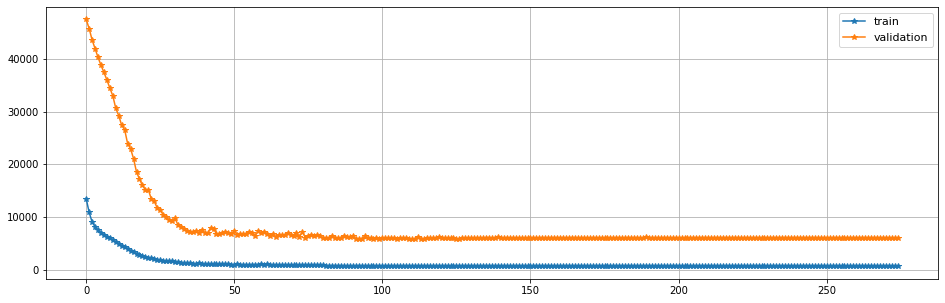

In [28]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [29]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [30]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 100, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
77/77 [==============================] - 49s 262ms/step - loss: 1348.8799 - mae: 1348.8799 - val_loss: 4589.1504 - val_mae: 4589.1504
Epoch 2/100
77/77 [==============================] - 11s 147ms/step - loss: 1002.3085 - mae: 1002.3085 - val_loss: 5749.9434 - val_mae: 5749.9434
Epoch 3/100
77/77 [==============================] - 23s 302ms/step - loss: 868.3774 - mae: 868.3774 - val_loss: 4425.6099 - val_mae: 4425.6099
Epoch 4/100
77/77 [==============================] - 18s 233ms/step - loss: 805.6570 - mae: 805.6570 - val_loss: 4394.9736 - val_mae: 4394.9736
Epoch 5/100
77/77 [==============================] - 19s 244ms/step - loss: 778.5013 - mae: 778.5013 - val_loss: 3769.3228 - val_mae: 3769.3228
Epoch 6/100
77/77 [==============================] - 11s 145ms/step - loss: 795.8153 - mae: 795.8153 - val_loss: 4885.3096 - val_mae: 4885.3096
Epoch 7/100
77/77 [==============================] - 12s 154ms/step - loss: 768.5040 - mae: 768.5040 - val_loss: 5348.4004 - val_mae

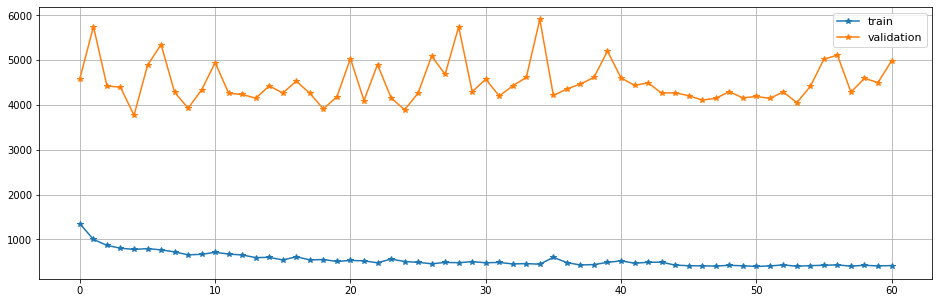

In [31]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [32]:
best_model = tf.keras.models.load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 52ms/step - loss: 3769.3225 - mae: 3769.3225


[3769.322509765625, 3769.322509765625]

# Images created 

In [33]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

45/45 [==============================] - 0s 3ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

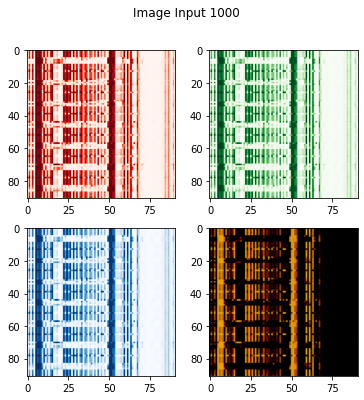

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


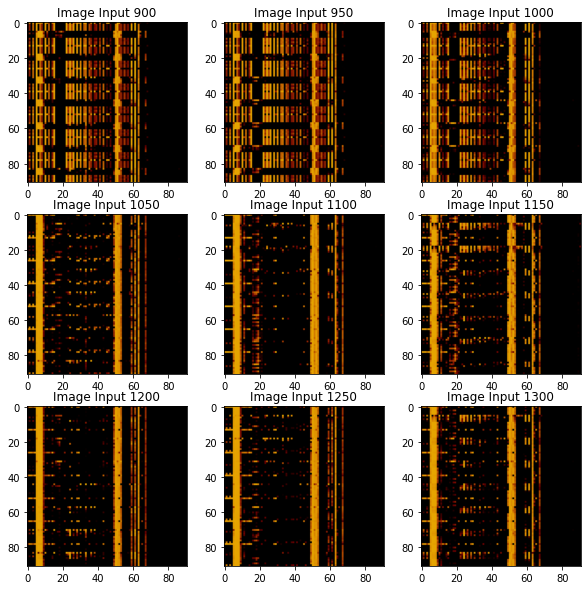

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,1350,50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

In [36]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

45/45 [==============================] - 2s 48ms/step


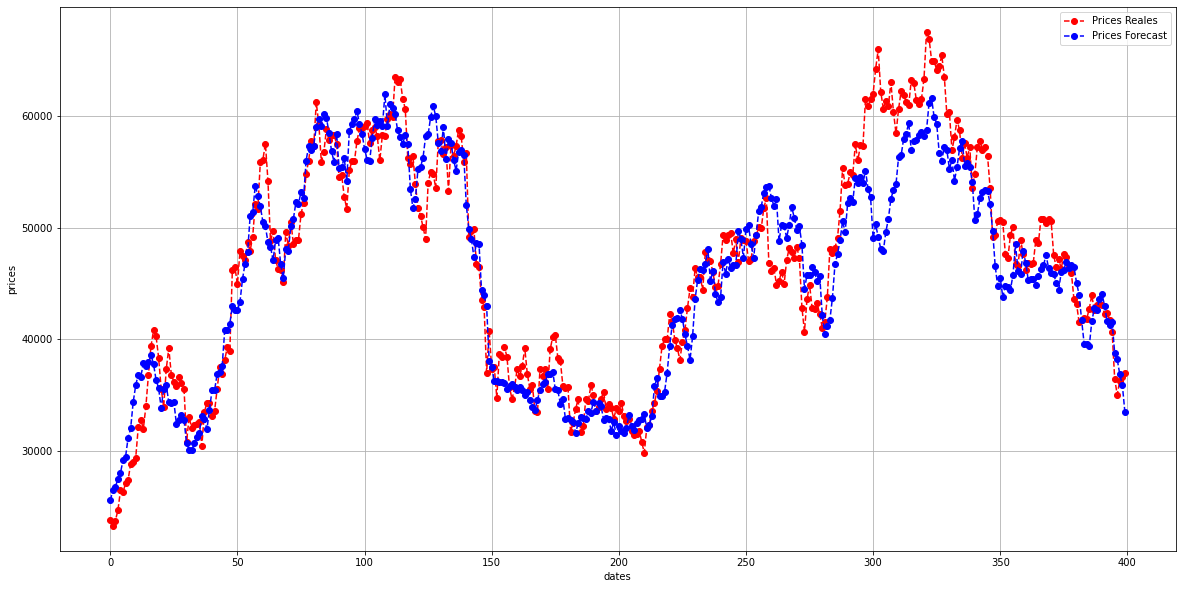

In [37]:
c = 400
day_pred = 0

fig=plt.figure(figsize=(20, 10))
plt.plot(y[-c:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[-c:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [38]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [39]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [40]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std     min      25%      50%      75%       max
0  200.0  5980.67  3264.29  726.99  3508.72  5264.25  7814.72  17280.53
Errores Full
    count     mean      std    min     25%     50%     75%       max
0  1420.0  2017.22  2609.16  65.89  425.59  825.75  2784.7  17280.53


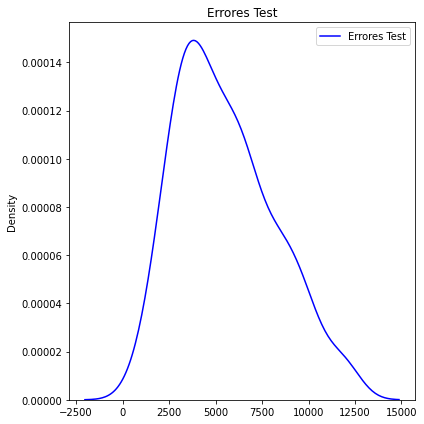

In [41]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

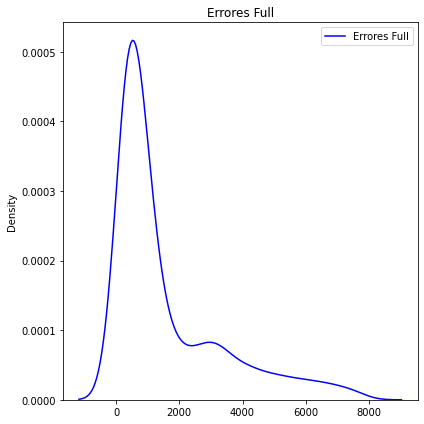

In [42]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [43]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

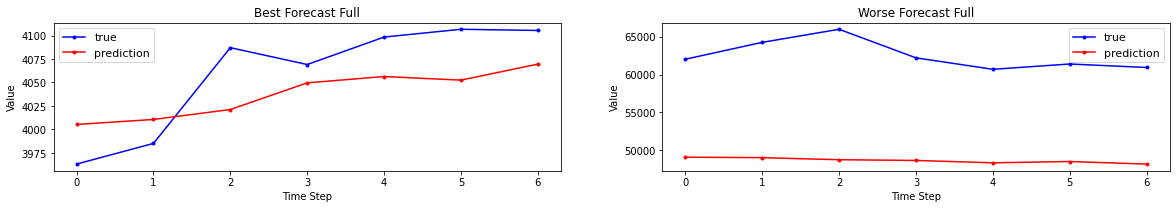

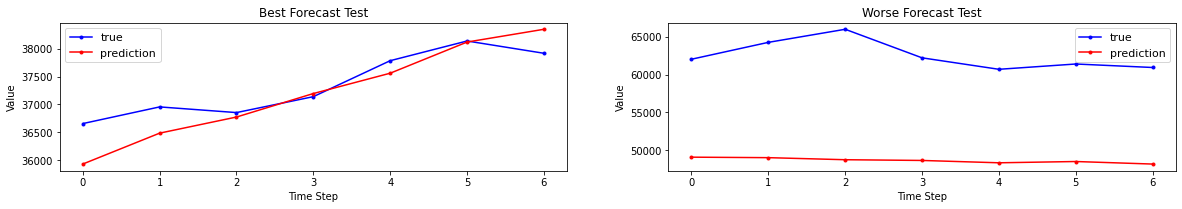

In [44]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();